In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
%reload_ext autoreload
%autoreload 2
import json
import logging
import numpy as np
import pandas as pd
import os
import itertools
from pyeed import Pyeed
import matplotlib.pyplot as plt
from pyeed.analysis.embedding_analysis import EmbeddingTool
from pyeed.analysis.sequence_alignment import PairwiseAligner
from scipy.spatial.distance import pdist, squareform


/home/nab/anaconda3/envs/pyeed_niklas_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SetUp

In [3]:
import os

load_dotenv()  # Load variables from .env
password = os.getenv("NEO4J_NIKLAS_PLAYGROUND")
if password is None:
    raise ValueError("KEY is not set in the .env file.")

In [26]:
uri = "bolt://127.0.0.1:7687"
user = "neo4j"

eedb = Pyeed(uri, user=user, password=password)
# eedb.db.wipe_database(date='2025-01-20')

Pyeed Graph Object Mapping constraints not defined. Use _install_labels() to set up model constraints.
📡 Connected to database.


In [27]:
et = EmbeddingTool()

In [4]:
# read in the pandas dataframe
df = pd.read_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', sep=';')
print(df.head())

# df.to_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', sep=';', index=False)


  protein_name phenotype    protein_id protein_id_database
0        TEM-1        2b      AAP20891          AAP20891.1
1        TEM-2        2b      CAJ85677          CAJ85677.1
2        TEM-3       2be      SAQ02853          SAQ02853.1
3        TEM-4       2be      CDR98216          CDR98216.1
4        TEM-5       2be  WP_109963600      WP_109963600.1


In [5]:
ids = df['protein_id_database'].dropna().tolist()
labels = df['phenotype'].tolist()

# pd.nan should be None
labels = [None if pd.isna(x) else x for x in labels]

dict_id_label = {}
for i in range(len(ids)):
    dict_id_label[ids[i]] = labels[i]

print(len(ids))
print(len(labels))


209
265


In [30]:
# eedb.fetch_from_primary_db(ids=ids, db="ncbi_protein")

# eedb.calculate_sequence_embeddings(model_name="esmc_300m")

In [31]:
# pa = PairwiseAligner()
# pa.align_multipairwise(ids=ids, db=eedb.db)

# Data SetUp

In [32]:
print(len(ids))

209


[{'seq_length': 286, 'protein_id': 'AAP20891.1'}, {'seq_length': 286, 'protein_id': 'CAJ85677.1'}, {'seq_length': 286, 'protein_id': 'SAQ02853.1'}, {'seq_length': 286, 'protein_id': 'CDR98216.1'}, {'seq_length': 286, 'protein_id': 'WP_109963600.1'}, {'seq_length': 286, 'protein_id': 'CAA41038.1'}, {'seq_length': 286, 'protein_id': 'WP_109874025.1'}, {'seq_length': 286, 'protein_id': 'CAA46344.1'}, {'seq_length': 286, 'protein_id': 'APG33178.1'}, {'seq_length': 286, 'protein_id': 'AKC98298.1'}, {'seq_length': 286, 'protein_id': 'KJO56189.1'}, {'seq_length': 286, 'protein_id': 'KLP91446.1'}, {'seq_length': 286, 'protein_id': 'CAA46346.1'}, {'seq_length': 286, 'protein_id': 'CAA74912.2'}, {'seq_length': 286, 'protein_id': 'AFN21551.1'}, {'seq_length': 286, 'protein_id': 'ACB22021.1'}, {'seq_length': 286, 'protein_id': 'CAA76794.1'}, {'seq_length': 286, 'protein_id': 'CAA76795.1'}, {'seq_length': 286, 'protein_id': 'CCG28759.1'}, {'seq_length': 286, 'protein_id': 'KLG19745.1'}, {'seq_lengt

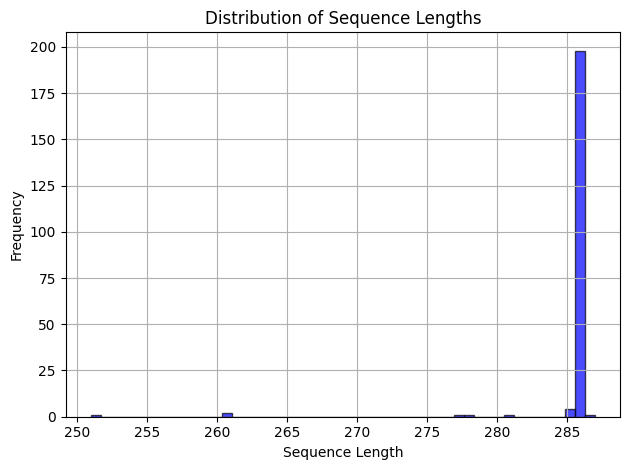

In [33]:
# plot the length distribution of the sequences
# the attribute is called seq_length in the protein node and return the ids as well
# we can get the data from the database
query_seq_length = """
MATCH (p:Protein)
WHERE p.accession_id IN $ids
RETURN p.seq_length AS seq_length, p.accession_id AS protein_id
"""
seq_lengths = eedb.db.execute_read(query_seq_length, {"ids": ids})
print(seq_lengths)
seq_lengths_data = [record["seq_length"] for record in seq_lengths]
print(seq_lengths_data)

plt.hist(seq_lengths_data, bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()

In [34]:
# exclude all sequneces with a different length from 286
ids = []
for i in range(len(seq_lengths_data)):
    if seq_lengths_data[i] == 286:
        ids.append(seq_lengths[i]["protein_id"])

print(len(ids))


198


In [35]:
# next up is the comaprision of embeddings vs identity
# we want a graph x is cosine similarity and y is identity
# we have all of the data in the database so we can just query it

# first we want the PAIRWISE_ALINED realtionship between the proteins from ids
# second we want thhe embeddduing of the proteins from ids
# we can then calculate the cosine similarity between the embeddings and the identity
query_pairwise = """
MATCH (p1:Protein)-[r:PAIRWISE_ALIGNED]-(p2:Protein)
WHERE p1.accession_id IN $ids AND p2.accession_id IN $ids
RETURN p1.accession_id AS protein1, p2.accession_id AS protein2, r.similarity AS identity, r.target_aligned AS target_aligned, r.query_aligned AS query_aligned, r.mismatches AS mismatches
"""
results_pairwise = eedb.db.execute_read(query_pairwise, {"ids": ids})
print(results_pairwise[:10])

# create a distance matrix based on the pairwise alignment
# the metric used will be identity
# results_pairwise is a list of dictionaries with keys protein1, protein2, identity
# the distance matrix is a numpy array, and there is a list of the protein ids which are the same as the order of the distance matrix
distance_matrix_pairwise = np.zeros((len(ids), len(ids)))
# protein_ids_pairwise is a list of the protein ids which are the same as the order of the distance matrix
# is should have a length of ids, the x and y axis of the distance matrix are the same
protein_ids_pairwise = []

for i in ids:
    for j in ids:
        if i == j:
            distance_matrix_pairwise[ids.index(i), ids.index(j)] = 1
        else:
            # this is the new identity, we look at the target and query seq and find remove all positions with a '-'
            # then we count the number of mismatches and divide by the length of the sequence
            # the identity is 1 - the number of mismatches / the length of the sequence

            # get the data from the results_pairwise
            target_aligned = next(
                (record["target_aligned"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), ''
            )
            query_aligned = next(
                (record["query_aligned"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), ''
            )
            mismatches = next(
                (record["mismatches"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), 0
            )

            """
            # remove the '-' from the target and query aligned
            remove_indices = []
            for k in range(len(target_aligned)):
                if target_aligned[k] == '-':
                    remove_indices.append(k)
                elif query_aligned[k] == '-':
                    remove_indices.append(k)
                
            # remove the indices from the target and query aligned
            target_aligned = ''.join([target_aligned[k] for k in range(len(target_aligned)) if k not in remove_indices])
            query_aligned = ''.join([query_aligned[k] for k in range(len(query_aligned)) if k not in remove_indices])

            # calculate the identity
            identity = 1 - mismatches / len(target_aligned)
            """

            identity = next((record["identity"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), 0)

            distance_matrix_pairwise[ids.index(i), ids.index(j)] = identity
            
    protein_ids_pairwise.append(i)

    


print(len(protein_ids_pairwise))
print(distance_matrix_pairwise.shape)


[{'protein1': 'AAP20891.1', 'protein2': 'AAZ14083.2', 'identity': 0.993006993006993, 'target_aligned': 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLMRSALPAGWFIADKSGAGERGSHGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW', 'query_aligned': 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW', 'mismatches': 2}, {'protein1': 'AAP20891.1', 'protein2': 'AAL68923.1', 'identity': 0.993006993006993, 'target_aligned': 'MSIQHFRVALIPFFAAFCFPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTT

KeyboardInterrupt: 

In [39]:
np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_pairwise_default_methode_ESM3.npy', distance_matrix_pairwise)
np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_pairwise_default_methode_ESM3.npy', protein_ids_pairwise)


In [40]:
query_embedding = """
MATCH (p:Protein)
WHERE p.accession_id IN $ids
RETURN p.accession_id AS protein, p.embedding AS embedding
"""
results_embedding = eedb.db.execute_read(query_embedding, {"ids": ids})

# create a distance matrix based on the embeddings
# the metric used will be cosine similarity
# result is a numpy array and there is a list of the protein ids which are the same as the order of the distance matrix
distance_matrix_embedding = np.zeros((len(ids), len(ids)))
protein_ids_embedding = []

# use pdist to calculate the cosine similarity
# use squareform to get the distance matrix
embeddings = [record["embedding"] for record in results_embedding]
distance_matrix_embeddings_cosine = squareform(pdist(embeddings, metric="cosine"))
distance_matrix_embeddings_euclidean = squareform(pdist(embeddings, metric="euclidean"))
protein_ids_embedding = [record["protein"] for record in results_embedding]

In [41]:
np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_cosine_ESM3.npy', distance_matrix_embeddings_cosine)
np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_euclidean_ESM3.npy', distance_matrix_embeddings_euclidean)
np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_embedding_ESM3.npy', protein_ids_embedding)


# Data Loading

In [6]:
# we now load the previously saved distance matrix and protein ids
distance_matrix_embeddings_cosine = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_cosine.npy")
distance_matrix_embeddings_euclidean = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_euclidean.npy")
protein_ids_embedding = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_embedding.npy")

distance_matrix_pairwise = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_pairwise_default_methode.npy")
protein_ids_pairwise = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_pairwise_default_methode.npy")

distance_matrix_mutations = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_mutations.npy")
protein_ids_mutations = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_mutations.npy")

In [7]:
distance_matrix_pairwise_ESM3 = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_pairwise_default_methode_ESM3.npy")
protein_ids_pairwise_ESM3 = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_pairwise_default_methode_ESM3.npy")

distance_matrix_embeddings_cosine_ESM3 = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_cosine_ESM3.npy")
distance_matrix_embeddings_euclidean_ESM3 = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_euclidean_ESM3.npy")
protein_ids_embedding = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_embedding_ESM3.npy")


In [ ]:
# matrix sizes should be the same
print(distance_matrix_pairwise.shape)
print(distance_matrix_embeddings_cosine.shape)
print(distance_matrix_embeddings_euclidean.shape)

print(len(protein_ids_pairwise))
print(len(protein_ids_embedding)//2)
print((len(protein_ids_embedding)//2)**2)


(209, 209)
(209, 209)
(209, 209)
209
99
9801


In [38]:
print(protein_ids_pairwise[:5])
print(protein_ids_embedding[:5])

['AAP20891.1' 'CAJ85677.1' 'SAQ02853.1' 'CDR98216.1' 'WP_109963600.1']
['AAP20891.1' 'CAJ85677.1' 'SAQ02853.1' 'CDR98216.1' 'WP_109963600.1']


# Plots

In [39]:
embedding_tool = EmbeddingTool()

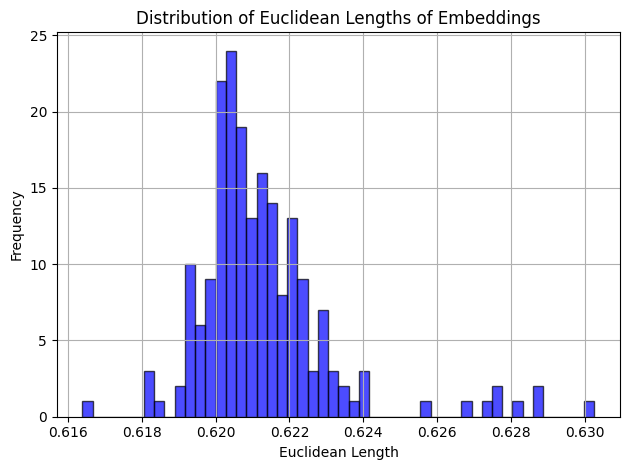

In [50]:
# i want all of the embeddings from the database for all ids
embeddings_all = []

for i in range(len(ids)):
    embeddings_all.append(embedding_tool.get_embedding(ids[i], db=eedb.db))

embeddings_all = np.array(embeddings_all)

# get the histogram plot of the euclidean length of the embeddings
plt.hist(np.linalg.norm(embeddings_all, axis=1), bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Euclidean Lengths of Embeddings")
plt.xlabel("Euclidean Length")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()


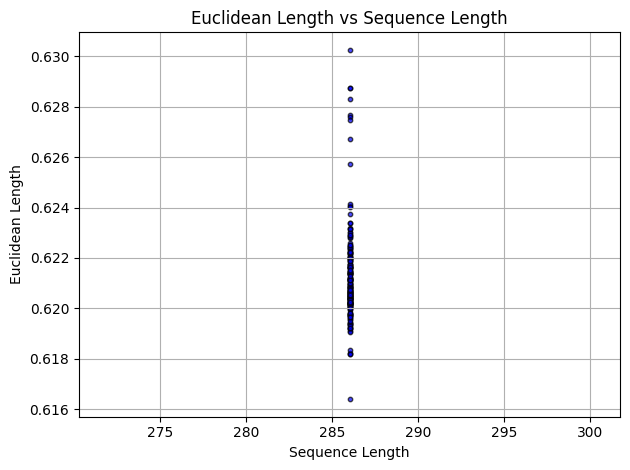

In [51]:
# now i want a 2d plot of the euclidean length of the embeddings vs the sequence length
for i in range(len(ids)):
    # get the sequence length from neo4j, there is a attribute in the protein node called seq_length
    query_seq_length = f"""
    MATCH (p:Protein)
    WHERE p.accession_id = $id
    RETURN p.seq_length AS seq_length
    """
    seq_length = eedb.db.execute_read(query_seq_length, {"id": ids[i]})[0]['seq_length']

    euclidean_length = np.linalg.norm(embeddings_all[i])
    plt.scatter(seq_length, euclidean_length, c='blue', alpha=0.7, s=10, edgecolor="k")
plt.title("Euclidean Length vs Sequence Length")
plt.xlabel("Sequence Length")
plt.ylabel("Euclidean Length")
plt.grid()
plt.tight_layout()
plt.show()


/home/nab/anaconda3/envs/pyeed_niklas/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Number of proteins in visualization: 209
{None, '2br', '2ber', '2be', '2b'}
{None: 'black', '2br': 'orange', '2ber': 'purple', '2be': 'red', '2b': 'blue'}


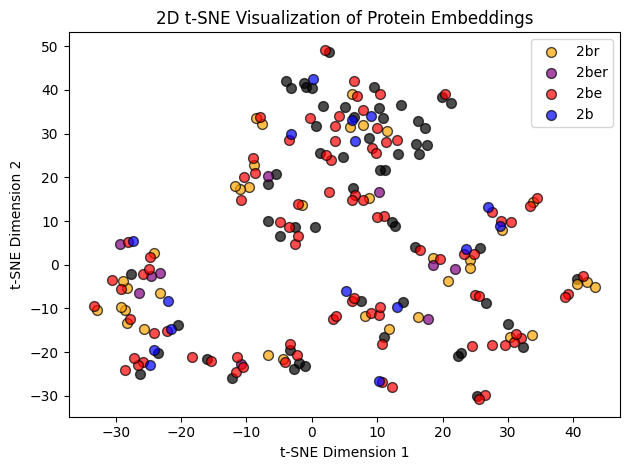

In [55]:
# get all of the data from embedding
protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=8, n_iter=3000)

print(f"Number of proteins in visualization: {len(protein_ids)}")

# make the None objects to 'None' in labels
labels_all = ['None' if x is None else x for x in labels]

# create a scatter plot for each unique label
unique_labels = set(labels)
unique_color_labels = {}
print(unique_labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )
    
    # store the color for the label
    unique_color_labels[label] = colors[indices[0]]

print(unique_color_labels)

plt.title("2D t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
print(len(labels))
print(len(protein_ids))
print(len(colors))
print(len(embeddings_2d))


209
209
209
209


 Length of protein_ids_mutations: 198
 Length of protein_ids_pairwise: 198


/tmp/ipykernel_2076493/510733642.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


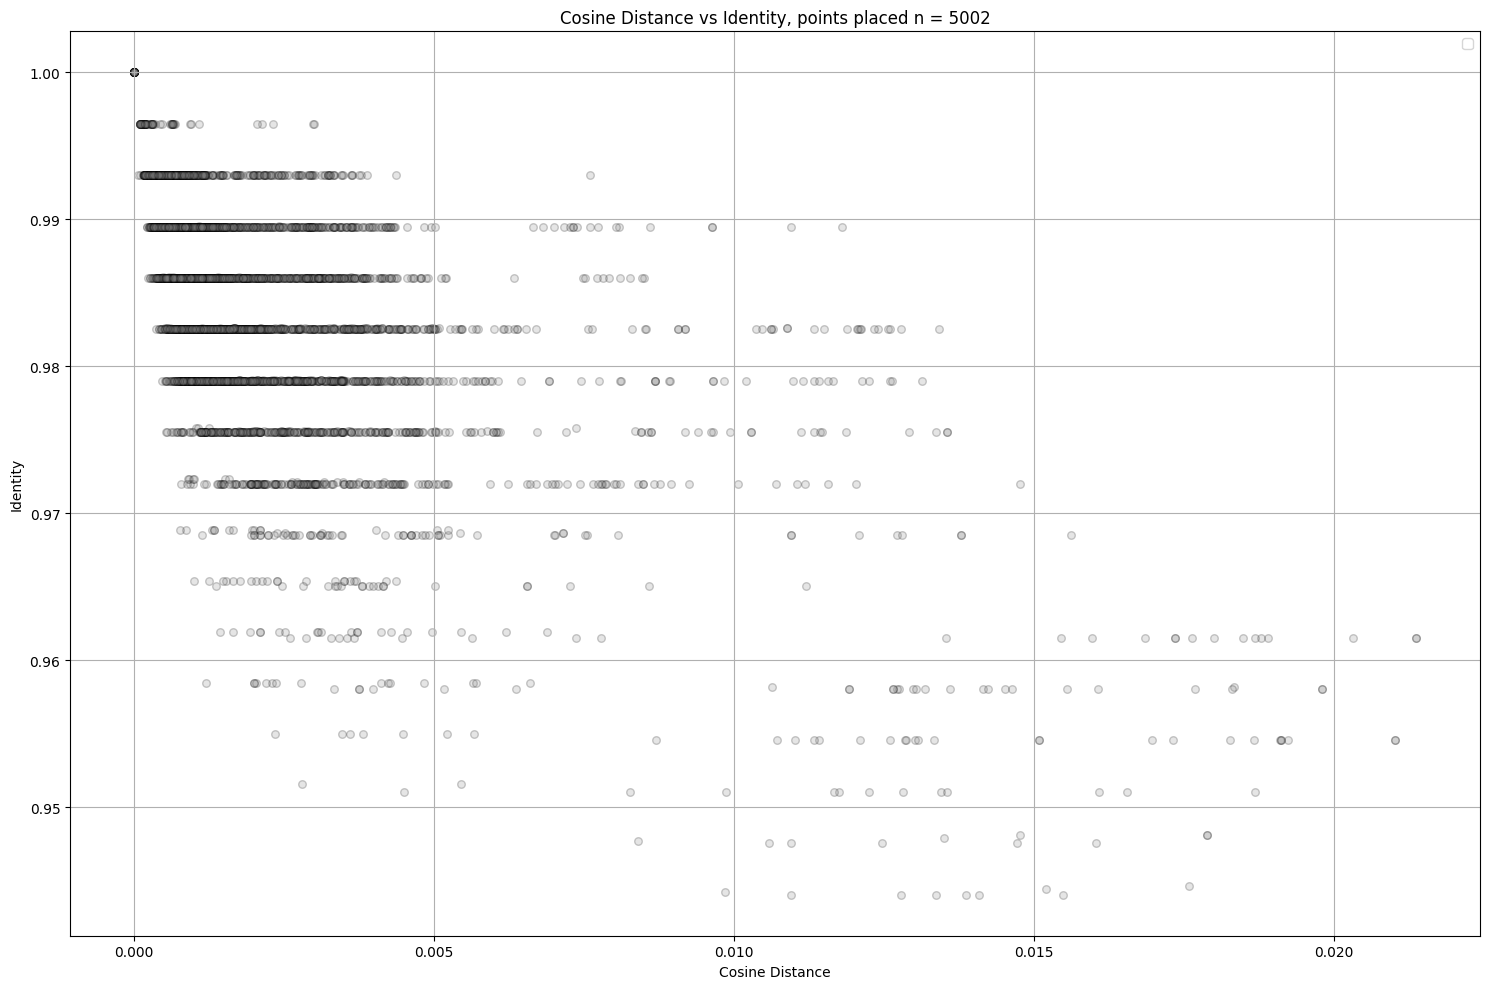

In [19]:
fig = plt.figure(figsize=(15, 10))

number_of_points_goal = 5000
total_number_of_points = distance_matrix_pairwise.shape[0] * distance_matrix_pairwise.shape[1]
random_chance_probability = number_of_points_goal / total_number_of_points
point_counter = 0

data_matrix = []

protein_ids_embedding = np.array(protein_ids_embedding)
protein_ids_pairwise = np.array(protein_ids_pairwise)

print(f" Length of protein_ids_mutations: {len(protein_ids_embedding)}")
print(f" Length of protein_ids_pairwise: {len(protein_ids_pairwise)}")

for i in range(len(protein_ids_embedding)):
    for j in range(len(protein_ids_pairwise)):

        if np.random.rand() < random_chance_probability:
            # plt.scatter(distance_matrix_mutations[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            # does not work since the ids are not the same

            mutations_id = protein_ids_embedding[i]
            pairwise_id = protein_ids_pairwise[j]

            if mutations_id == pairwise_id:
                plt.scatter(distance_matrix_embeddings_cosine[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
                data_matrix.append([distance_matrix_embeddings_cosine[i, j], distance_matrix_pairwise[i, j], mutations_id, pairwise_id])
            else:
                # we need to find the index of the pairwise_id in the protein_ids_mutations array from numpy
                # the i is the index in the protein_ids_mutations array this means we are looking of the index to j in the protein_ids_mutations array
                index_mutations_id = np.where(protein_ids_embedding == pairwise_id)[0][0]
                # now the index of the mutations_id is the index of the pairwise_id in the protein_ids_pairwise array
                index_pairwise_id = np.where(protein_ids_pairwise == mutations_id)[0][0]

                plt.scatter(distance_matrix_embeddings_cosine[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], c='gray', alpha=0.2, s=30, edgecolor="k")
                data_matrix.append([distance_matrix_embeddings_cosine[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], mutations_id, pairwise_id])
            
            point_counter += 1
        
        if point_counter > number_of_points_goal:
            break
        
    
plt.title("Cosine Distance vs Identity, points placed n = " + str(point_counter))
plt.xlabel("Cosine Distance")
plt.ylabel("Identity")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


(209, 2)


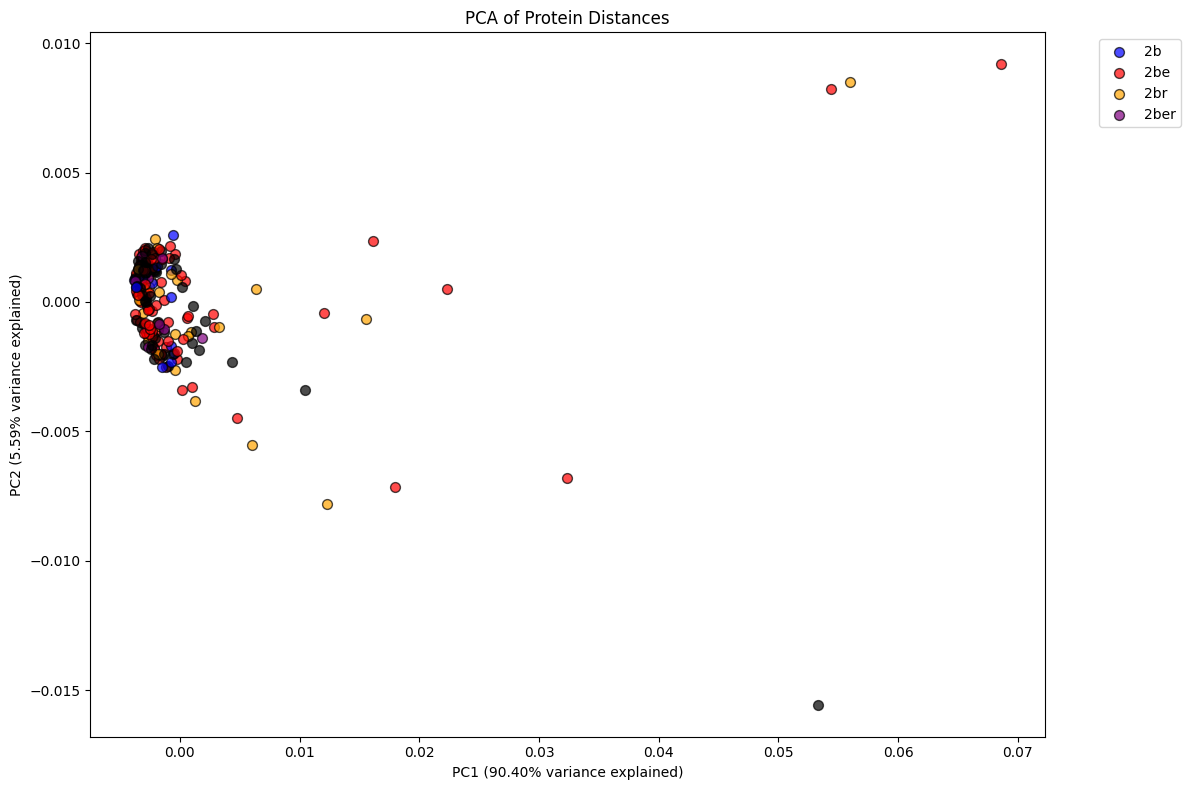


Explained variance ratio:
PC1: 90.40%
PC2: 5.59%
Total: 95.98%


In [57]:
from sklearn.decomposition import PCA

# Create PCA object
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization

# Fit and transform the distance matrix
# Using the cosine distance matrix, but you could also use euclidean or mutations
pca_result = pca.fit_transform(distance_matrix_embeddings_cosine)
print(pca_result.shape)

# Create the visualization
plt.figure(figsize=(12, 8))

# set up the colors for the labels
colors = [unique_color_labels[label] for label in labels]
plotted_label = []

for i in range(len(labels)):
    
    if labels[i] not in plotted_label:
        plt.scatter(
            pca_result[i, 0],
            pca_result[i, 1],
            alpha=0.7,
            c=colors[i],
            s=50,
            edgecolor="k",
            label=labels[i],
        )
        plotted_label.append(labels[i])
    else:
        plt.scatter(
            pca_result[i, 0],
            pca_result[i, 1],
            alpha=0.7,
            c=colors[i],
            s=50,
            edgecolor="k",
        )

plt.title("PCA of Protein Distances")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Print explained variance ratio
print("\nExplained variance ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca.explained_variance_ratio_[:2]):.2%}")

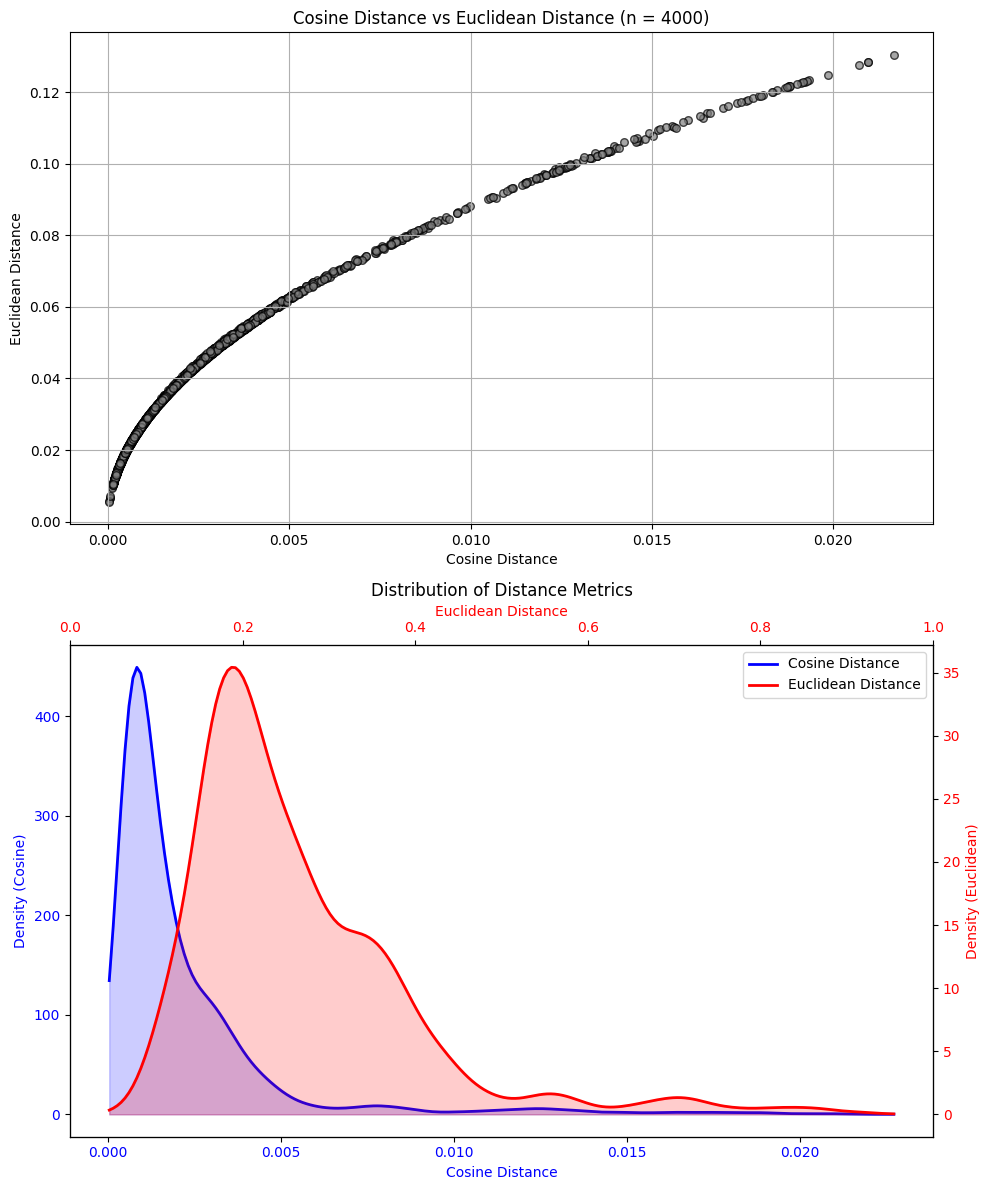

In [61]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# First subplot - Scatter plot
count_points = 0
combinations_of_indexes = list(itertools.combinations(range(len(protein_ids)), 2))
total_number = len(combinations_of_indexes)
random_choices = np.random.choice(total_number, 4000, replace=False)

for index in random_choices:
    i = combinations_of_indexes[index][0]
    j = combinations_of_indexes[index][1]
    if i == j:
        continue

    ax1.scatter(
        distance_matrix_embeddings_cosine[i, j],
        distance_matrix_embeddings_euclidean[i, j],
        alpha=0.7,
        s=30,
        c="gray",
        edgecolor="k",
    )
    count_points += 1
    if count_points > 20000:
        break

ax1.set_title(f"Cosine Distance vs Euclidean Distance (n = {count_points})")
ax1.set_xlabel("Cosine Distance")
ax1.set_ylabel("Euclidean Distance")
ax1.grid(True)

# Second subplot - Density plots with separate x and y axes
cosine_values = [
    distance_matrix_embeddings_cosine[i, j] for i, j in combinations_of_indexes[:20000]
]
euclidean_values = [
    distance_matrix_embeddings_euclidean[i, j]
    for i, j in combinations_of_indexes[:20000]
]

# Create density plots
density_cosine = gaussian_kde(cosine_values)
density_euclidean = gaussian_kde(euclidean_values)

xs_cosine = np.linspace(min(cosine_values), max(cosine_values), 200)
xs_euclidean = np.linspace(min(euclidean_values), max(euclidean_values), 200)

# Plot cosine distribution with left y-axis
ax2.plot(
    xs_cosine,
    density_cosine(xs_cosine),
    color="blue",
    label="Cosine Distance",
    linewidth=2,
)
ax2.fill_between(xs_cosine, density_cosine(xs_cosine), alpha=0.2, color="blue")
ax2.set_xlabel("Cosine Distance", color="blue")
ax2.set_ylabel("Density (Cosine)", color="blue")
ax2.tick_params(axis="x", labelcolor="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Create second x and y axes for euclidean distances
ax2_top = ax2.twiny()
ax2_right = ax2.twinx()

# Plot euclidean distribution with right y-axis
ax2_right.plot(
    xs_cosine,
    density_euclidean(xs_euclidean),
    color="red",
    label="Euclidean Distance",
    linewidth=2,
)
ax2_right.fill_between(
    xs_cosine, density_euclidean(xs_euclidean), alpha=0.2, color="red"
)
ax2_top.set_xlabel("Euclidean Distance", color="red")
ax2_right.set_ylabel("Density (Euclidean)", color="red")
ax2_top.tick_params(axis="x", labelcolor="red")
ax2_right.tick_params(axis="y", labelcolor="red")

# Add title and legend
ax2.set_title("Distribution of Distance Metrics")
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

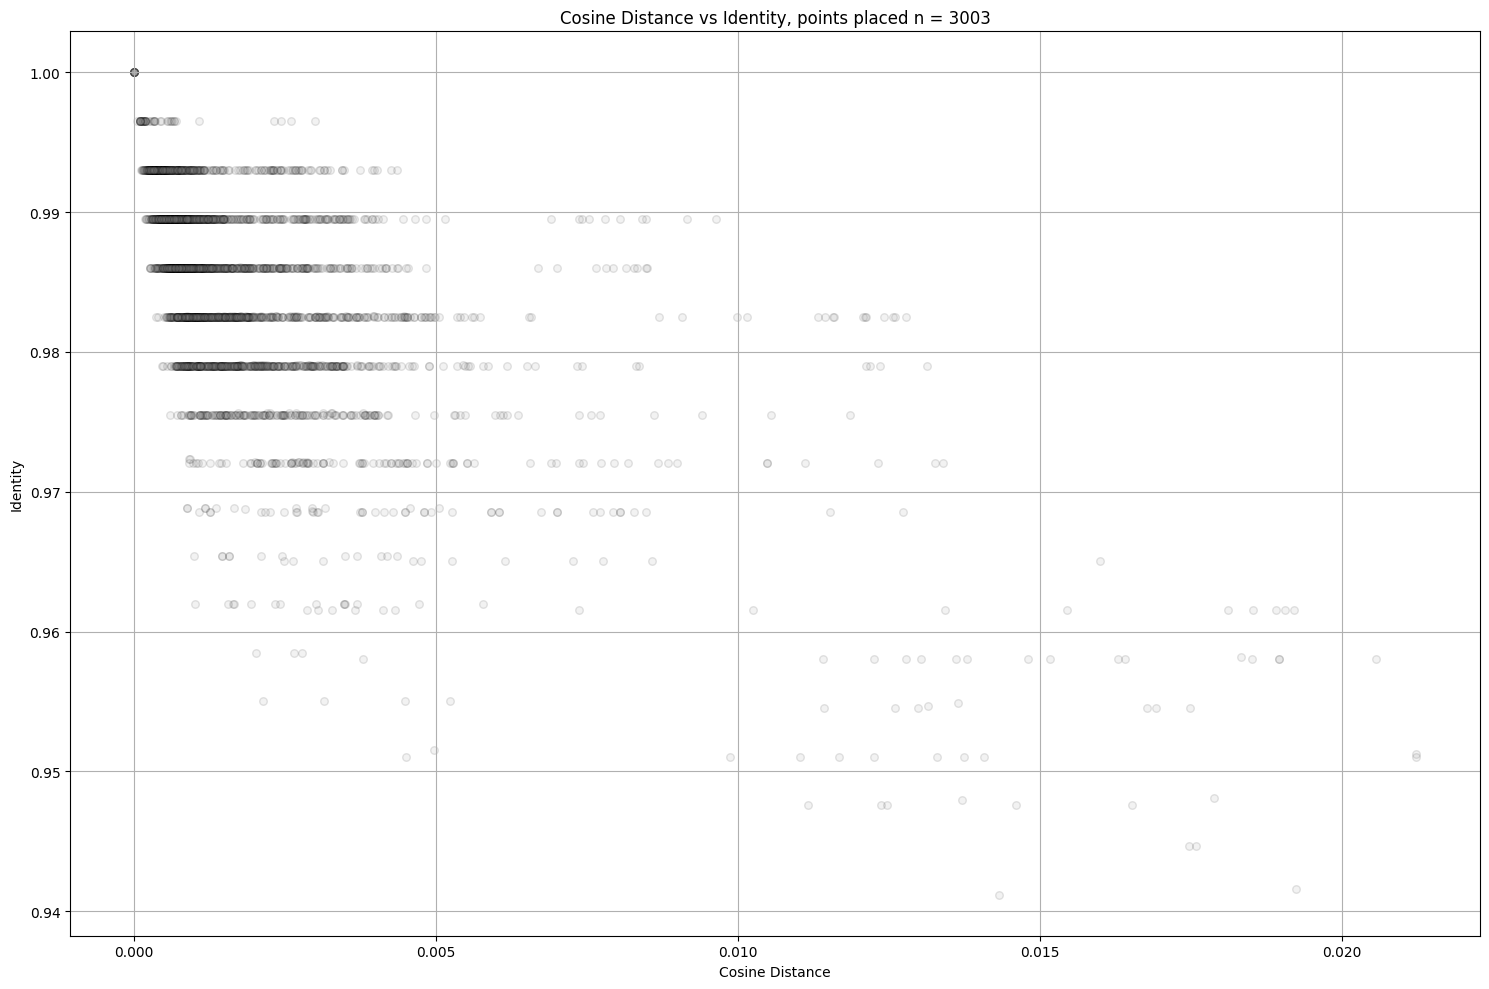

In [51]:
fig = et.plot_matrix_comparison(distance_matrix_embeddings_cosine, distance_matrix_pairwise, protein_ids_embedding, protein_ids_pairwise, "Cosine Distance", "Identity", 3000)
fig.show()

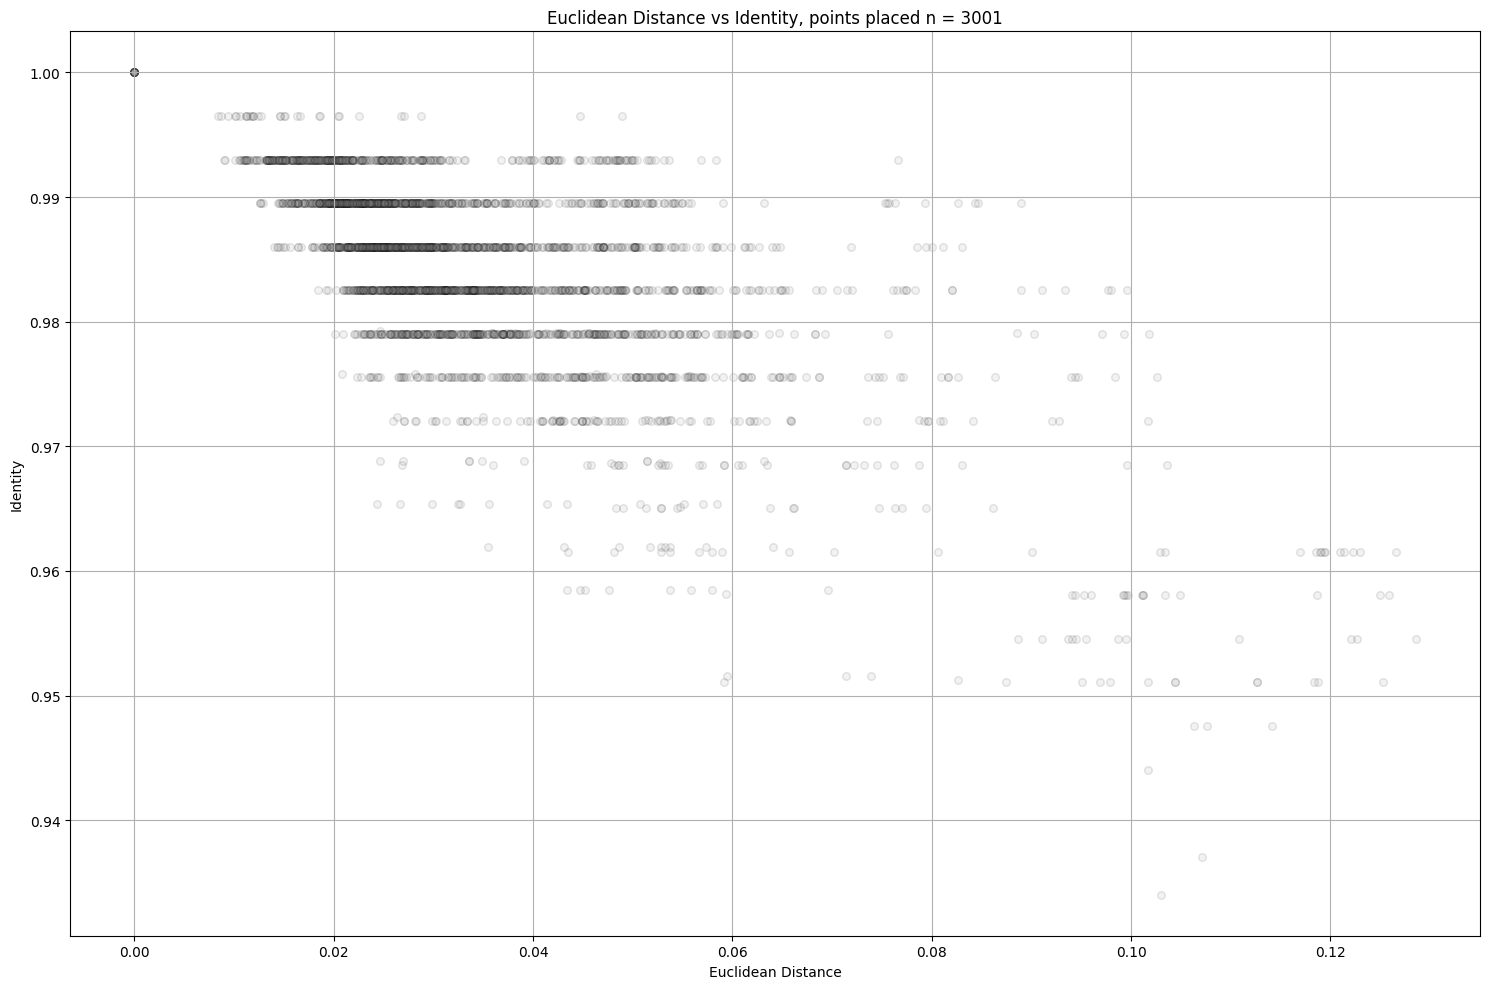

In [52]:
fig = et.plot_matrix_comparison(
    distance_matrix_embeddings_euclidean,
    distance_matrix_pairwise,
    protein_ids_embedding,
    protein_ids_pairwise,
    "Euclidean Distance",
    "Identity",
    3000,
)
fig.show()

In [53]:
data_matrix_ARRAY = np.array(data_matrix)
# the first column is the cosine similarity, the second is the identity, the third is the mutations_id and the fourth is the pairwise_id
# there fore the first two should be of type float and the last two of type string
data_matrix_ARRAY[:, 0] = data_matrix_ARRAY[:, 0].astype(float)
data_matrix_ARRAY[:, 1] = data_matrix_ARRAY[:, 1].astype(float)
data_matrix_ARRAY[:, 2] = data_matrix_ARRAY[:, 2].astype(str)
data_matrix_ARRAY[:, 3] = data_matrix_ARRAY[:, 3].astype(str)

print(data_matrix_ARRAY.shape)

# find the point with identity 1 and a cosine of bigger than 0.003
# then outpur the ids
for i in range(len(data_matrix_ARRAY)):
    if float(data_matrix_ARRAY[i, 1]) > 0.99999 and float(data_matrix_ARRAY[i, 0]) > 0.003:
        print('......................')
        print(data_matrix_ARRAY[i, 2], data_matrix_ARRAY[i, 3])
        print(f"Identity: {data_matrix_ARRAY[i, 1]}, Cosine Similarity: {data_matrix_ARRAY[i, 0]}")
        print(f"Label of {data_matrix_ARRAY[i, 2]}: {dict_id_label_new_ids_none[data_matrix_ARRAY[i, 2]]}")
        print(f"Label of {data_matrix_ARRAY[i, 3]}: {dict_id_label_new_ids_none[data_matrix_ARRAY[i, 3]]}")
        print('......................')
        print('\n')

(4953, 4)


# Stuff

/tmp/ipykernel_2071902/1700845601.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


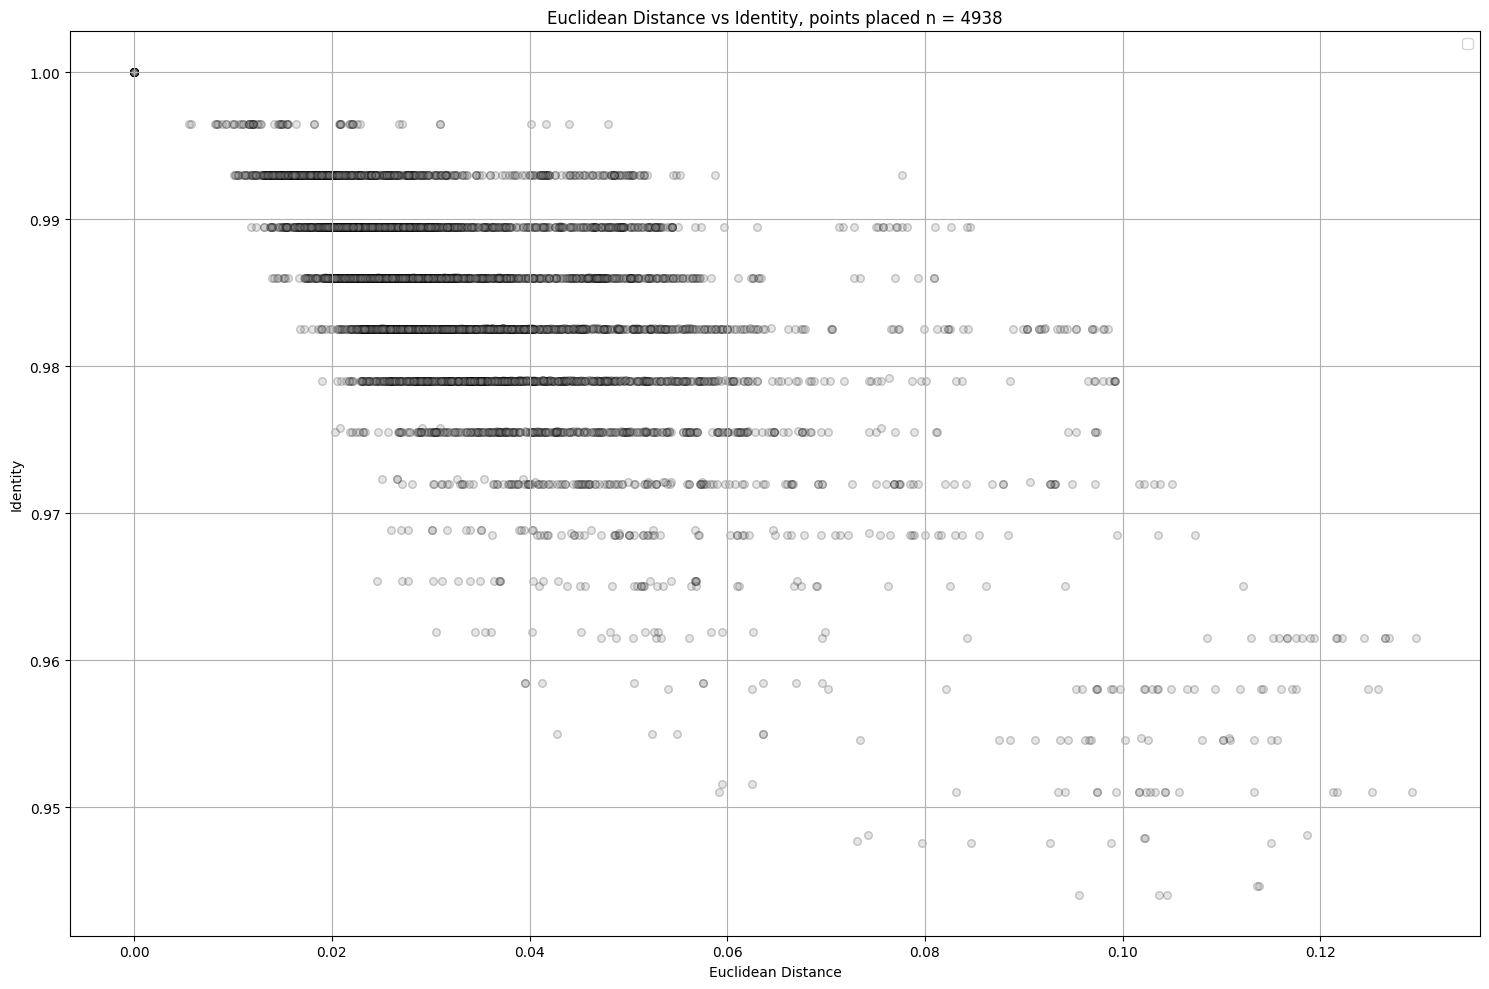

In [54]:
# same plot as before but with euclidean distance

fig = plt.figure(figsize=(15, 10))

number_of_points_goal = 5000
total_number_of_points = distance_matrix_embeddings_euclidean.shape[0] * distance_matrix_embeddings_euclidean.shape[1]
random_chance_probability = number_of_points_goal / total_number_of_points
point_counter = 0

for i in range(len(protein_ids_embedding)):
    for j in range(len(protein_ids_pairwise)):

        if np.random.rand() < random_chance_probability:
            # plt.scatter(distance_matrix_embedding_euclidean[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            # does not work since the ids are not the same

            mutations_id = protein_ids_embedding[i]
            pairwise_id = protein_ids_pairwise[j]

            if mutations_id == pairwise_id:
                plt.scatter(distance_matrix_embeddings_euclidean[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            else:
                # we need to find the index of the pairwise_id in the protein_ids_mutations array from numpy
                # the i is the index in the protein_ids_mutations array this means we are looking of the index to j in the protein_ids_mutations array
                index_mutations_id = np.where(protein_ids_embedding == pairwise_id)[0][0]
                # now the index of the mutations_id is the index of the pairwise_id in the protein_ids_pairwise array
                index_pairwise_id = np.where(protein_ids_pairwise == mutations_id)[0][0]

                plt.scatter(distance_matrix_embeddings_euclidean[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            
            point_counter += 1
        
plt.title("Euclidean Distance vs Identity, points placed n = " + str(point_counter))
plt.xlabel("Euclidean Distance")
plt.ylabel("Identity")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


19503


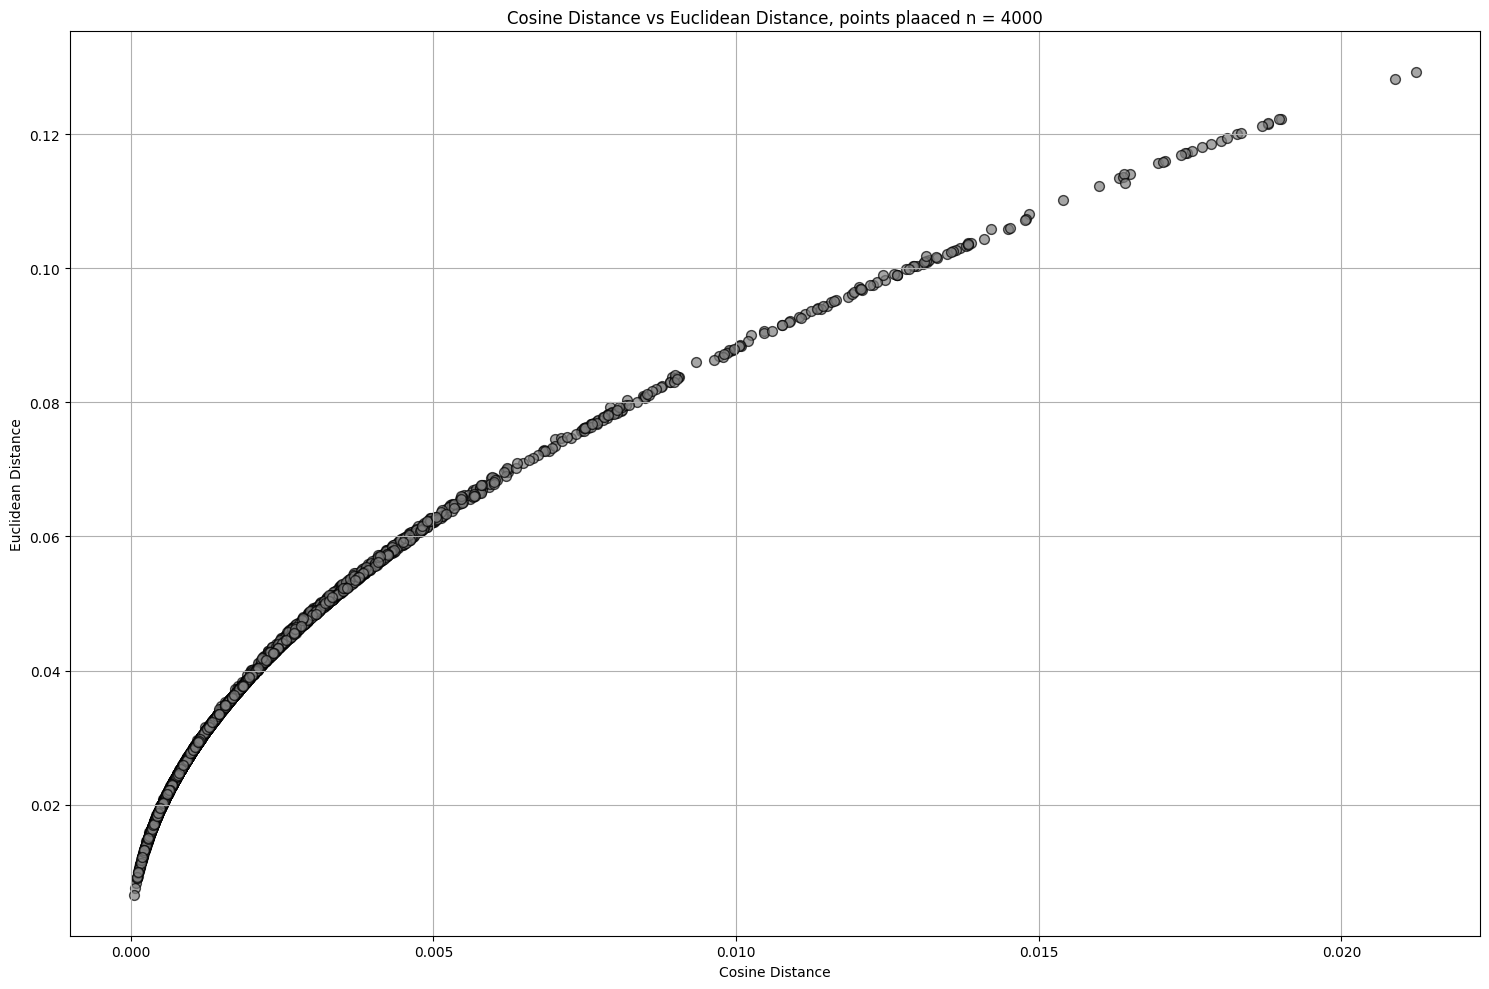

In [55]:
# create the scatter plot with cosine vs euclidian

fig = plt.figure(figsize=(15, 10))

# tracking
count_points = 0
already_plotted_labels = set()

# get all combinations of indexes but skip the second half of the matrix
combinations_of_indexes = list(itertools.combinations(range(len(protein_ids)), 2))
print(len(combinations_of_indexes))
total_number = len(combinations_of_indexes)
random_choices = np.random.choice(total_number, 4000, replace=False)


for index in random_choices:

    i = combinations_of_indexes[index][0]
    j = combinations_of_indexes[index][1]
    if i == j:
        continue

    

    plt.scatter(
        distance_matrix_embeddings_cosine[i, j],
        distance_matrix_embeddings_euclidean[i, j],
        label=label,
        alpha=0.7,
        s=50,
        c='gray',
        edgecolor="k",
    )

    count_points += 1

    if count_points > 20000:
        break

plt.title("Cosine Distance vs Euclidean Distance, points plaaced n = " + str(count_points))
plt.xlabel("Cosine Distance")
plt.ylabel("Euclidean Distance")
plt.grid()
plt.tight_layout()
plt.show()




In [56]:
# plot the distribution of the cosine similarity values on a histogram
# use the cosine similarity values from the distance matrix

plt.hist(distance_matrix_embedding_cosine.flatten(), bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Cosine Similarity Values")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()

NameError: name 'distance_matrix_embedding_cosine' is not defined

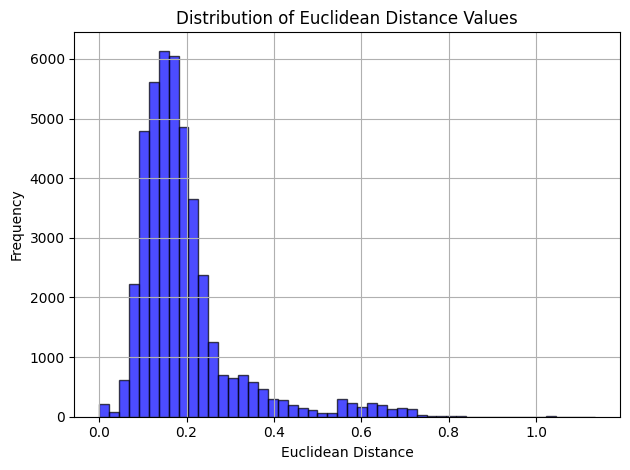

In [30]:
# plot the distribution of the euclidean distance values on a histogram
# use the euclidean distance values from the distance matrix

plt.hist(distance_matrix_embedding_euclidean.flatten(), bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Euclidean Distance Values")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()


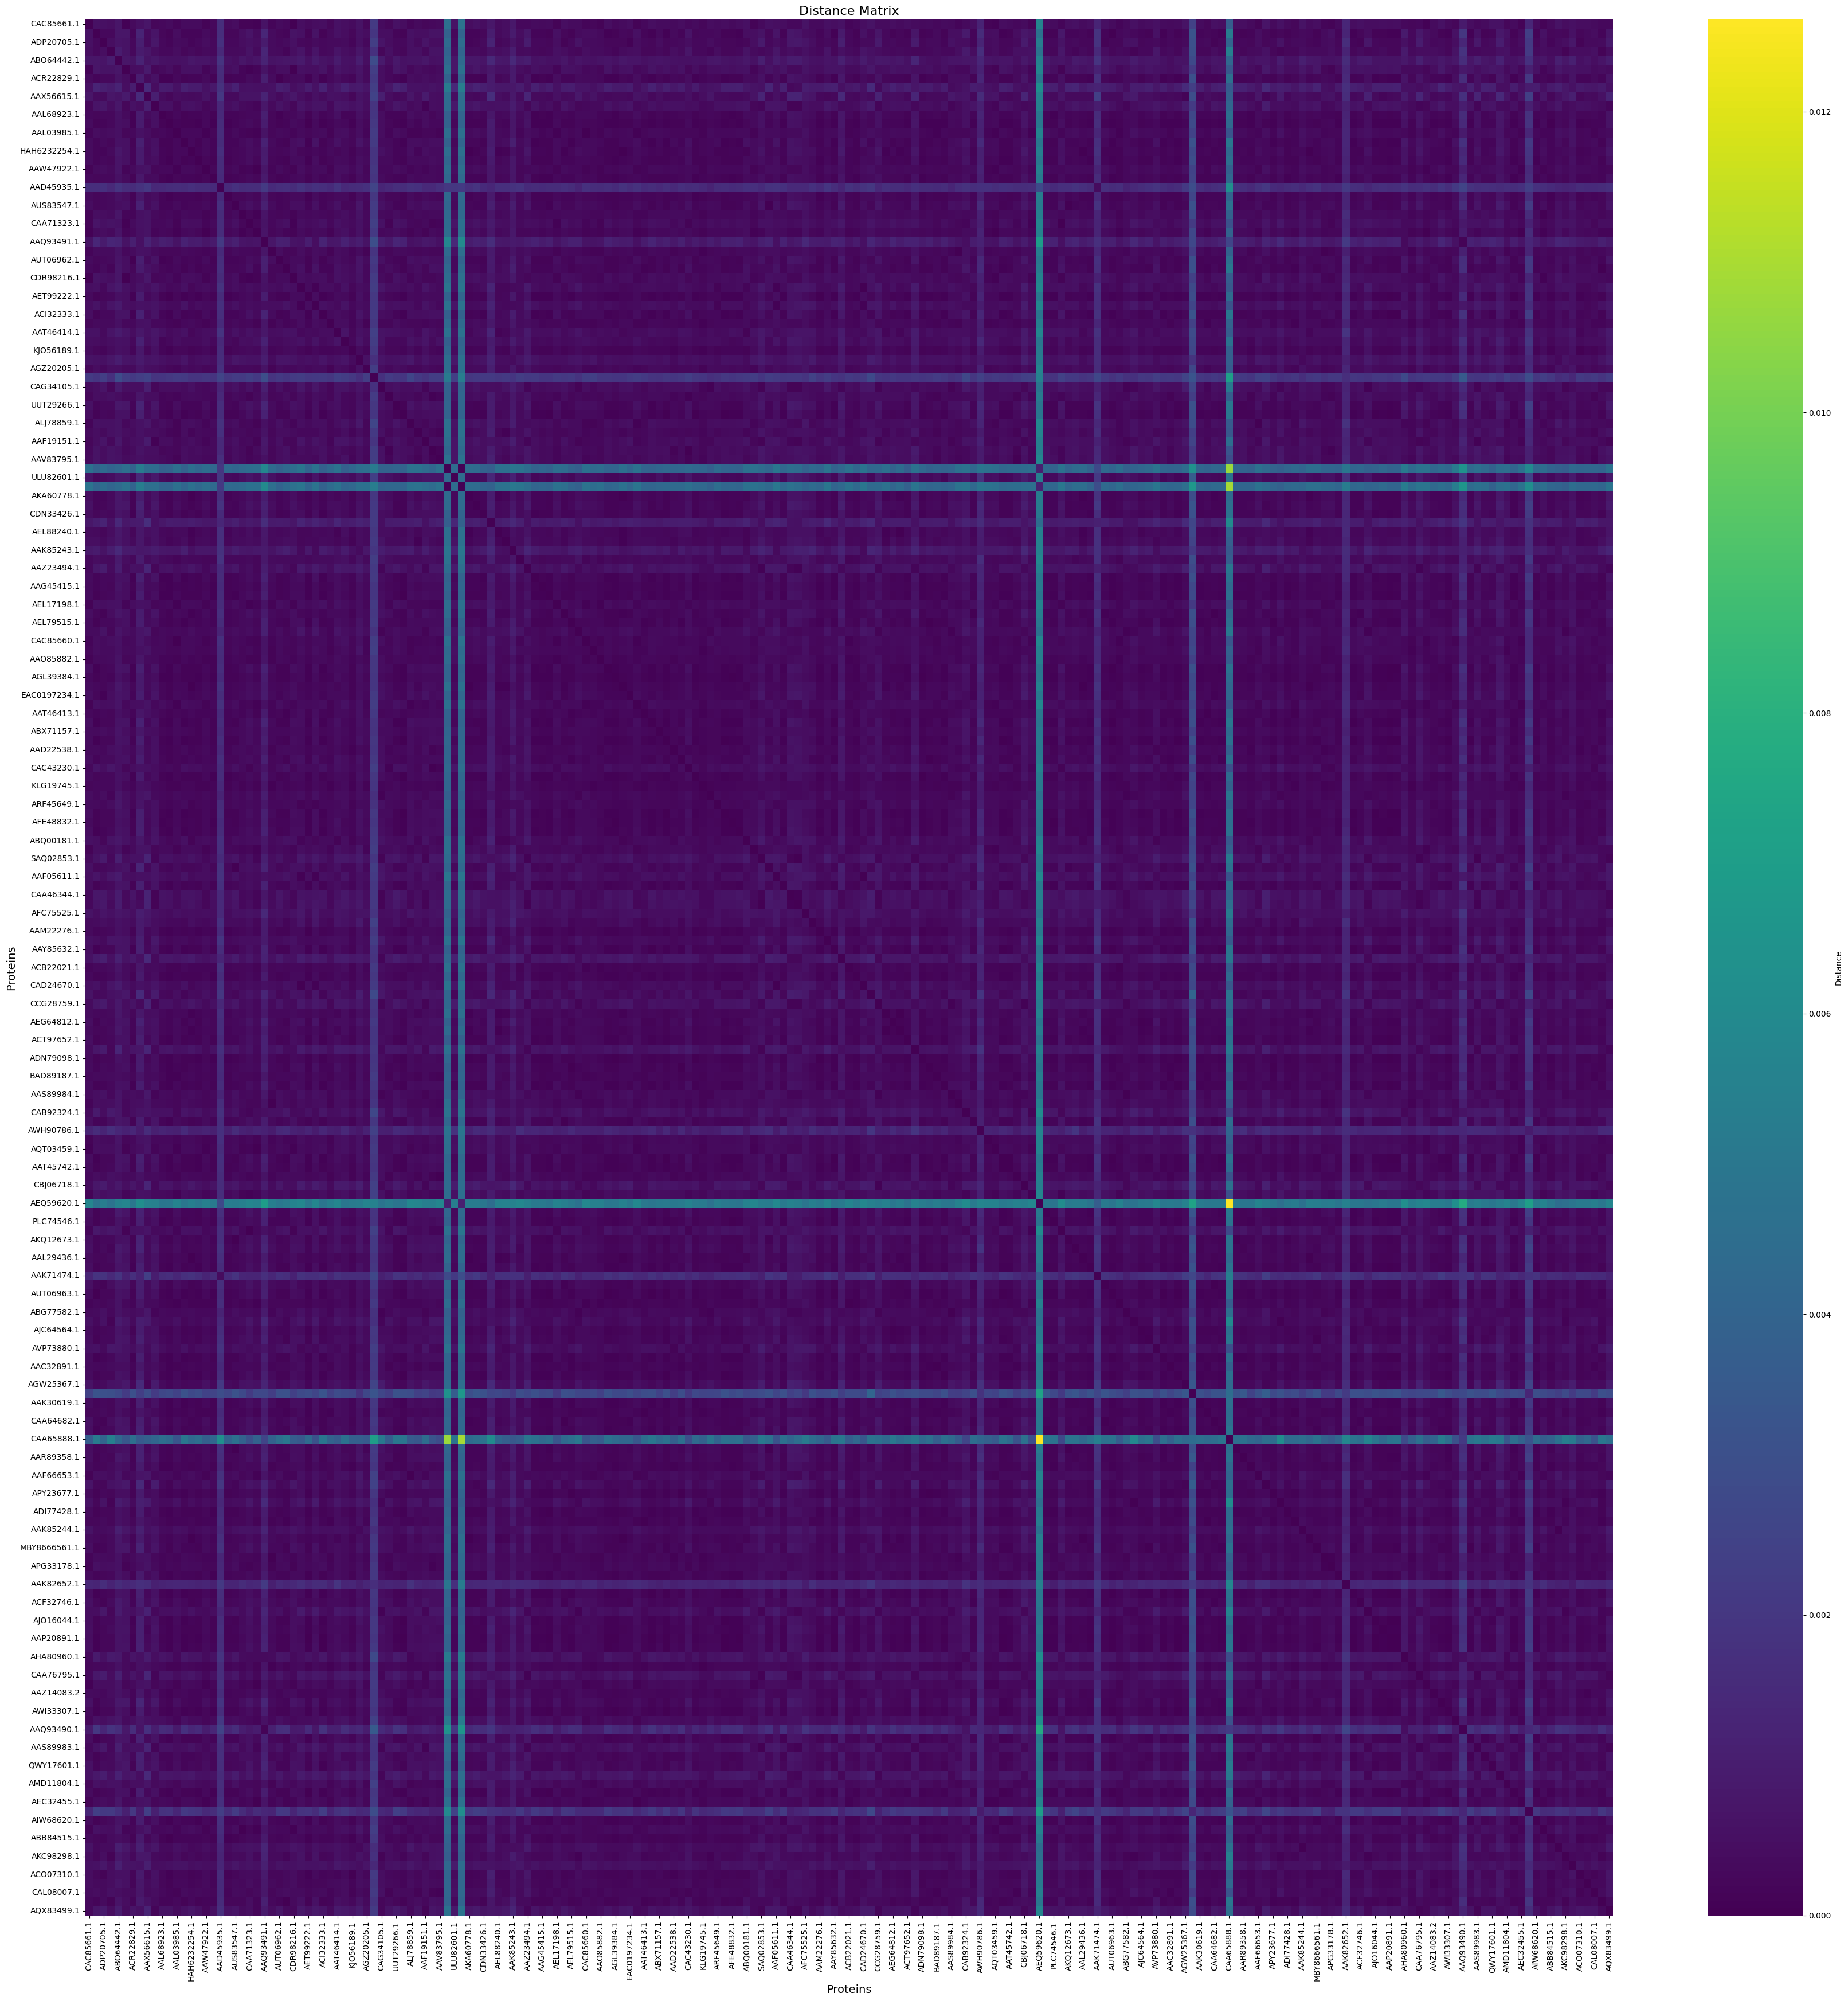